In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import json

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter


import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

from datetime import datetime

In [30]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [31]:
class_names = ['glioma', 'menin', 'tumor']

image_data = np.load('image_data.npy')
image_labels = np.load('image_labels.npy')

# update shape to match PyTorch's format (Examples, Channels, Height, Width)
updated_image_data_temp = np.swapaxes(image_data, 1, 3)
updated_image_data = np.swapaxes(updated_image_data_temp, 2, 3)

print('Orginal shape: ', image_data.shape)
print('New shape: ', updated_image_data.shape)

Orginal shape:  (6056, 256, 256, 3)
New shape:  (6056, 3, 256, 256)


In [32]:
# class for custom dataset needed for pytorch 
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# create train test splits
x_train, x_test, y_train, y_test = train_test_split(updated_image_data, image_labels, test_size=0.2, random_state=12, shuffle=True)

# encode labels numerically
label_encoder = LabelEncoder() 
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

training_set = CustomDataset(x_train, y_train)
test_set = CustomDataset(x_test, y_test)

In [33]:
# code for training on single epoch
def train_single_epoch(epoch_index, tb_writer, dloader, model, optimizer, loss,):
    running_loss_two = 0.0
    total_loss_two = 0.0  # Track total for the entire epoch
    
    for i, data in enumerate(dloader):
        inputs, labels = data
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)
        
        # Zero gradients
        optimizer.zero_grad()

        # Make predictions
        outputs = model(inputs)

        # Compute loss and gradients
        loss_two = loss(outputs, labels)
        loss_two.backward()

        # Adjust learning weights
        optimizer.step()

        # Accumulate losses
        batch_loss = loss_two.item()
        running_loss_two += batch_loss
        total_loss_two += batch_loss * inputs.size(0)  # Scale by batch size
        
        # Report every 1000 batches
        if i % 1000 == 999:
            avg_loss_two = running_loss_two / 1000
            print('  batch {} loss: {:.4f}'.format(i + 1, avg_loss_two))
            tb_x = epoch_index * len(dloader) + i + 1
            tb_writer.add_scalar('Loss/train', avg_loss_two, tb_x)
            running_loss_two = 0.0 
    
    # Return average loss for entire epoch
    epoch_loss_two = total_loss_two / len(dloader.dataset)
    return epoch_loss_two

In [36]:
# Custom Model
#Set up
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer_one = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
writer_two = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

# Paramaters
EPOCHS = 150 # number of epochs to run over
# initalize best loss tracker
best_vloss_one = 1_000_000.
best_vloss_two = 1_000_000.

k_fold_count = 5
kfold = KFold(n_splits=k_fold_count, shuffle=True, random_state=13)

# bunch of lists to catch various metrics
# each fold is 4/5 of the data, training 1/5 testing
train_label_count = int(round(len(training_set) * ((k_fold_count - 1)/k_fold_count)))
val_label_count = int(round(len(training_set) * (1 / (k_fold_count))))


# intalize dictionaries to hold data
model_one_data = {'train_loss' : dict(),
                        'true_labels' : dict(),
                        'predicted_labels' : dict(),
                        'val_loss' : dict(),
                        'val_accuracy' : dict(),
                        'val_probs' : dict(),
                        }

model_two_data = {'train_loss' : dict(),
                        'true_labels' : dict(),
                        'predicted_labels' : dict(),
                        'val_loss' : dict(),
                        'val_accuracy' : dict(),
                        'val_probs' : dict()
                        }

for fold, (train_index, val_index) in enumerate(kfold.split(training_set)):
    print(f'FOLD {fold + 1}')

    #initalize variables
    fold_train_loss_one = []
    fold_val_loss_list_one = []
    fold_val_accuracy_one = []

    fold_train_loss_two = []
    fold_val_loss_list_two = []
    fold_val_accuracy_two = []

    train_subset = Subset(training_set, train_index)
    val_subset = Subset(training_set, val_index)

    cv_train_loader_one = DataLoader(train_subset, batch_size=10, shuffle=True)
    cv_val_loader_one = DataLoader(val_subset, batch_size=10, shuffle=True)

    cv_train_loader_two = DataLoader(train_subset, batch_size=10, shuffle=True)
    cv_val_loader_two = DataLoader(val_subset, batch_size=10, shuffle=True)

    model_one = nn.Sequential(
        # First conv
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5), # 3 --> 32
        nn.ReLU(),

        # second conv layer
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # 32 --> 32 channels
        nn.ReLU(),
        nn.BatchNorm2d(32), # noramalization
        nn.MaxPool2d((2, 2)), # pooling into 2x2
        nn.Dropout2d(0.1), # remove 10% for regularization

        # third conv layer
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # 32 --> 64
        nn.ReLU(), # activation
        nn.BatchNorm2d(64), # noramalization
        nn.MaxPool2d((2, 2)), # pooling into 2x2 frames
        nn.Dropout2d(0.2), # remove 20% for regularization

        nn.AdaptiveAvgPool2d((4, 4)), # Avg pooling into 4x4 to reduce size
    
        nn.Flatten(), # drop to 1D
        nn.Linear(64*16, 128), # fully connected layer
        nn.ReLU(), # activation
        nn.Dropout(0.4),

        nn.Linear(128, len(class_names)) # Prediction Layer
    )

    # LAST MODIFICATION: Reduced first FC dropout from 20 --> 10
    model_two = nn.Sequential(
        # first conv layer
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5), # 3 --> 32 channels (input layer)
        nn.ReLU(),
    
        # second conv layer
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # 32 --> 32 channels (input layer)
        nn.ReLU(),

        nn.BatchNorm2d(64), # noramalization
        nn.MaxPool2d((2, 2)), # pooling into 2x2

        # this is a test of a setup from literature (Srinivasan et al., 2024)
        nn.ReLU(), # extra level of activation to add complexity without convolutional 
        nn.Dropout2d(0.1), # remove 10% for regularization (not in papers setup)
        nn.BatchNorm2d(64), 
        nn.MaxPool2d((2, 2)),

        # second conv layer
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5), # 64 --> 64
        nn.ReLU(), # activation

        nn.BatchNorm2d(64), # noramalization
        nn.MaxPool2d((2, 2)), # pooling into 2x2 frames
        nn.Dropout2d(0.15), # remove 15% for regularization

        nn.AdaptiveAvgPool2d((1, 1)), # Avg pooling into 4x4 to reduce size
    
        nn.Flatten(), # force to 1D
        nn.Linear(64, 32), # fully connected layer
        nn.ReLU(), # activation
        nn.Dropout(0.1), # remove 10% for regularization

        nn.Linear(32, 16), # hidden FC layer
        nn.ReLU(),
        nn.Dropout(0.5), # 50% dropout

        nn.Linear(16, len(class_names)) # Prediction Layer
    )

    # set to GPU for acceleration
    mps_device = torch.device("mps")
    model_one.to(mps_device)
    model_two.to(mps_device)

    # set loss and opimizer functions
    loss_fn = nn.CrossEntropyLoss()
    optimizer_one = torch.optim.Adam(model_one.parameters(), lr = 0.0002)
    optimizer_two = torch.optim.Adam(model_two.parameters(), lr = 0.0002)

    epoch_number = 0
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number +1))

        true_labels_list_one = []
        true_labels_list_two = []

        predicted_labels_list_one = []
        predicted_labels_list_two = []

        val_probs_one = []
        val_probs_two = []

        model_one.train(True)
        model_two.train(True)

        avg_loss_one = train_single_epoch(epoch_number, writer_one, cv_train_loader_one, model_one, optimizer_one, loss_fn)
        avg_loss_two = train_single_epoch(epoch_number, writer_two, cv_train_loader_two, model_two, optimizer_two, loss_fn)

        running_vloss_one = 0.0
        running_vloss_two = 0.0

        model_one.eval()
        model_two.eval()

        with torch.no_grad():
            # val one
            for i, vdata in enumerate(cv_val_loader_one):
                vinputs, vlabels = vdata
                vinputs = vinputs.to(mps_device)
                vlabels = vlabels.to(mps_device)
                voutputs = model_one(vinputs)
                _, predicted = torch.max(voutputs, 1)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss_one += vloss

                vlabels_one = vlabels.detach().cpu().tolist()
                predicted_one = predicted.detach().cpu().tolist()
                
                true_labels_list_one.extend(vlabels_one)
                predicted_labels_list_one.extend(predicted_one)
                # data for ROC_curve
                probabilities = nn.functional.softmax(voutputs, dim=1)
                probabilities_arr = probabilities.detach().cpu().tolist()
                val_probs_one.extend(probabilities_arr)

            #val two
            for i, vdata in enumerate(cv_val_loader_two):
                vinputs, vlabels = vdata
                vinputs = vinputs.to(mps_device)
                vlabels = vlabels.to(mps_device)
                voutputs = model_two(vinputs)
                _, predicted = torch.max(voutputs, 1)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss_two += vloss

                vlabels_two = vlabels.cpu().tolist()
                predicted_two = predicted.cpu().tolist()

                true_labels_list_two.extend(vlabels_two)
                predicted_labels_list_two.extend(predicted_two)

                # data for ROC_curve
                probabilities = nn.functional.softmax(voutputs, dim=1)
                probabilities_arr = probabilities.cpu().tolist()
                val_probs_two.extend(probabilities_arr)

        fold_val_accuracy_one.append(metrics.accuracy_score(vlabels_one, predicted_one))           
        fold_val_accuracy_two.append(metrics.accuracy_score(vlabels_two, predicted_two))
    
        avg_vloss_one = running_vloss_one / (i + 1)
        avg_vloss_two = running_vloss_two / (i + 1)

        print('Model 1 Loss train {} valid {}'.format(avg_loss_one, avg_vloss_one))
        print('Model 2 Loss train {} valid {}'.format(avg_loss_two, avg_vloss_two))

        fold_val_loss_list_one.append(avg_vloss_one.cpu().item())
        fold_val_loss_list_two.append(avg_vloss_two.cpu().item())

        fold_train_loss_one.append(avg_loss_one)
        fold_train_loss_two.append(avg_loss_two)

        writer_one.add_scalars('Training vs. Validation Loss',
                       {'Training' : avg_loss_one, 'Validation' : avg_vloss_one},
                       epoch_number + 1)
    
        writer_two.add_scalars('Training vs. Validation Loss',
                       {'Training' : avg_loss_two, 'Validation' : avg_vloss_two},
                       epoch_number + 1)
    
        writer_one.flush()
        writer_two.flush()

        if avg_vloss_one < best_vloss_one:
            best_vloss_one = avg_vloss_one
            model_path = 'model_one_{}_{}'.format(timestamp, epoch_number)
            torch.save(model_one.state_dict(), model_path)

        if avg_vloss_two < best_vloss_two:
            best_vloss_two = avg_vloss_two
            model_path = 'model_two_{}_{}'.format(timestamp, epoch_number)
            torch.save(model_two.state_dict(), model_path)
    
        # early stopping protocol
        if avg_vloss_one < 0.09 and avg_vloss_two < 0.09:
            print(f"STOPPED REACH - Final Loss: {avg_vloss_one}, {avg_vloss_two}")
            break
        epoch_number += 1
    
    #update dictionaries
    model_one_data['val_accuracy'][fold] = fold_val_accuracy_one
    model_one_data['train_loss'][fold] = fold_train_loss_one
    model_one_data['val_loss'][fold] = fold_val_loss_list_one
    model_one_data['val_probs'][fold] = val_probs_one
    model_one_data['predicted_labels'][fold] = predicted_labels_list_one
    model_one_data['true_labels'][fold] = true_labels_list_one

    model_two_data['val_accuracy'][fold] = fold_val_accuracy_two
    model_two_data['train_loss'][fold] = fold_train_loss_two
    model_two_data['val_loss'][fold] = fold_val_loss_list_two
    model_two_data['val_probs'][fold] = val_probs_two
    model_two_data['predicted_labels'][fold] = predicted_labels_list_two
    model_two_data['true_labels'][fold] = true_labels_list_two

print('Training complete')

FOLD 1
EPOCH 1:
Model 1 Loss train 0.6560849153226421 valid 0.6555263996124268
Model 2 Loss train 1.0221517507491573 valid 0.8876245021820068
EPOCH 2:
Model 1 Loss train 0.5458452297410658 valid 0.7167680859565735
Model 2 Loss train 0.7664297922195927 valid 0.660102367401123
EPOCH 3:
Model 1 Loss train 0.4898839577551811 valid 0.40323585271835327
Model 2 Loss train 0.6025262894553522 valid 0.5655801892280579
EPOCH 4:
Model 1 Loss train 0.42378519237041473 valid 0.42600616812705994
Model 2 Loss train 0.5424427729652774 valid 0.45254048705101013
EPOCH 5:
Model 1 Loss train 0.3788733817108216 valid 0.28848403692245483
Model 2 Loss train 0.5003423929022205 valid 0.37812843918800354
EPOCH 6:
Model 1 Loss train 0.31414112096832647 valid 0.5245863795280457
Model 2 Loss train 0.5466341251903964 valid 0.4239253103733063
EPOCH 7:
Model 1 Loss train 0.2860665243960196 valid 0.29445505142211914
Model 2 Loss train 0.5017148164779909 valid 0.3940913677215576
EPOCH 8:
Model 1 Loss train 0.25923998248

In [40]:
with open('model_one_data.json', 'w') as f:
    json.dump(model_one_data, f)

with open('model_two_data.json', 'w') as f:
    json.dump(model_two_data, f)



Classification Report Model One - Fold 1:
               precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       314
       menin       0.94      0.96      0.95       319
       tumor       0.97      0.97      0.97       336

    accuracy                           0.97       969
   macro avg       0.97      0.97      0.97       969
weighted avg       0.97      0.97      0.97       969

Classification Report Model Two - Fold 1:
               precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       314
       menin       0.96      0.95      0.95       319
       tumor       0.96      0.98      0.97       336

    accuracy                           0.97       969
   macro avg       0.97      0.97      0.97       969
weighted avg       0.97      0.97      0.97       969

Classification Report Model One - Fold 2:
               precision    recall  f1-score   support

      glioma       0.97      0.99      0.98       328


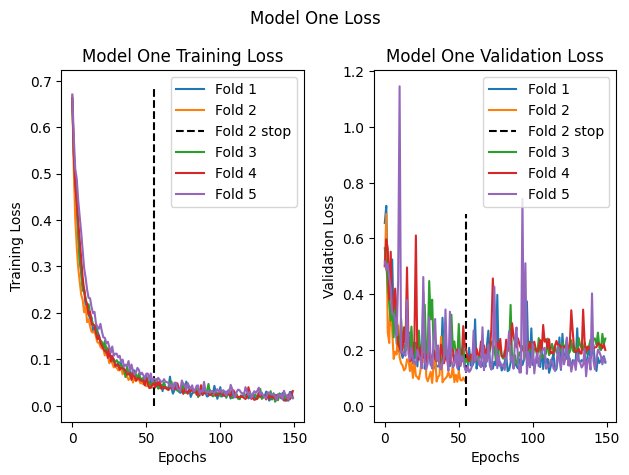

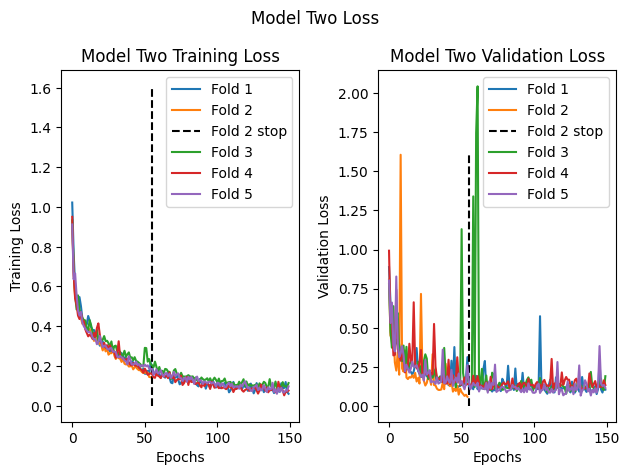

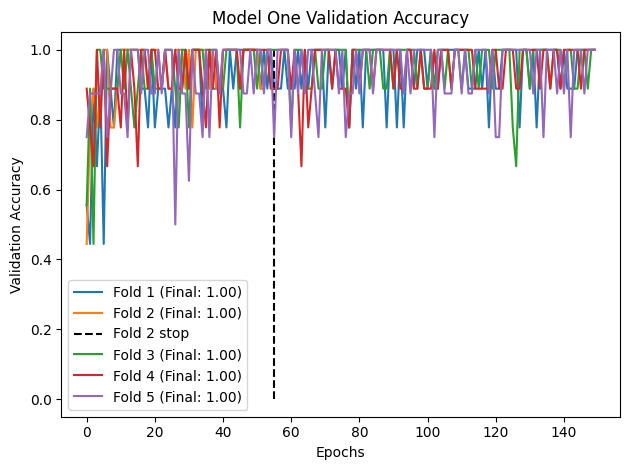

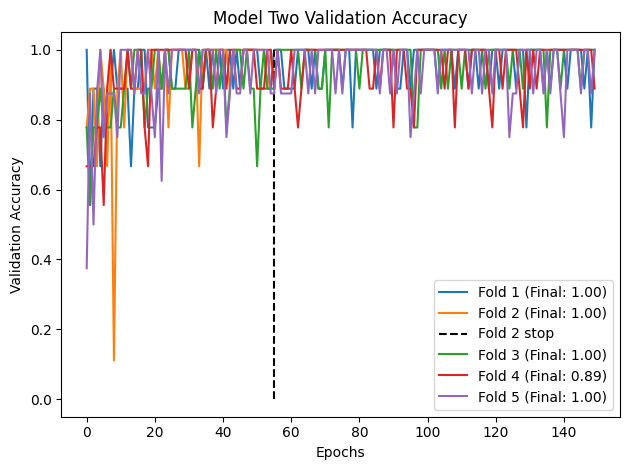

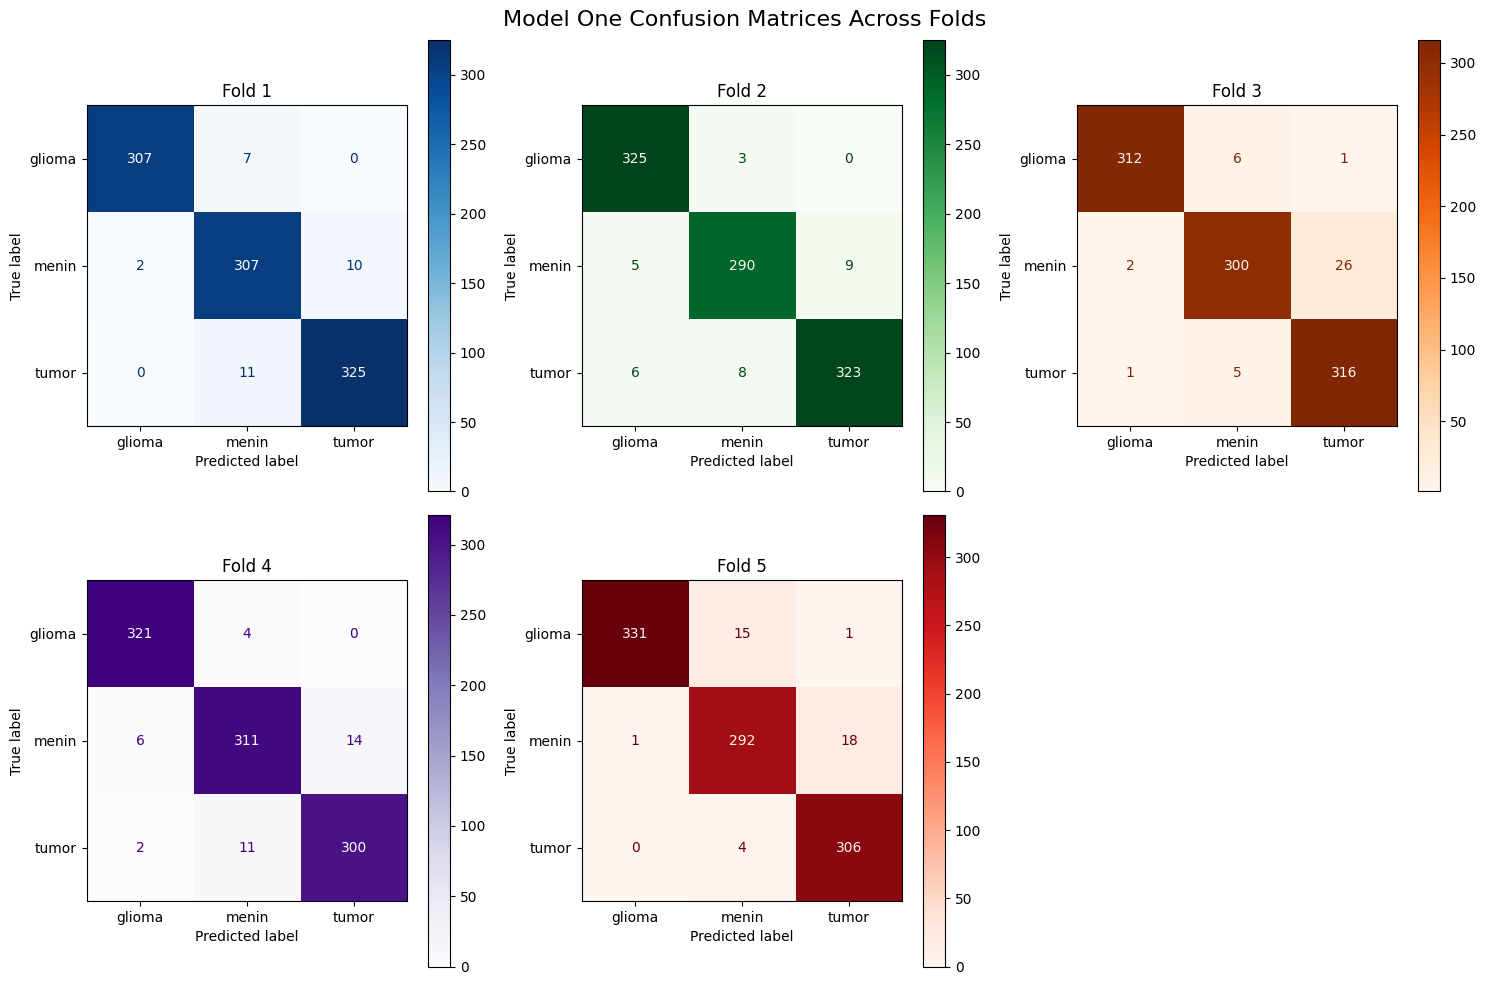

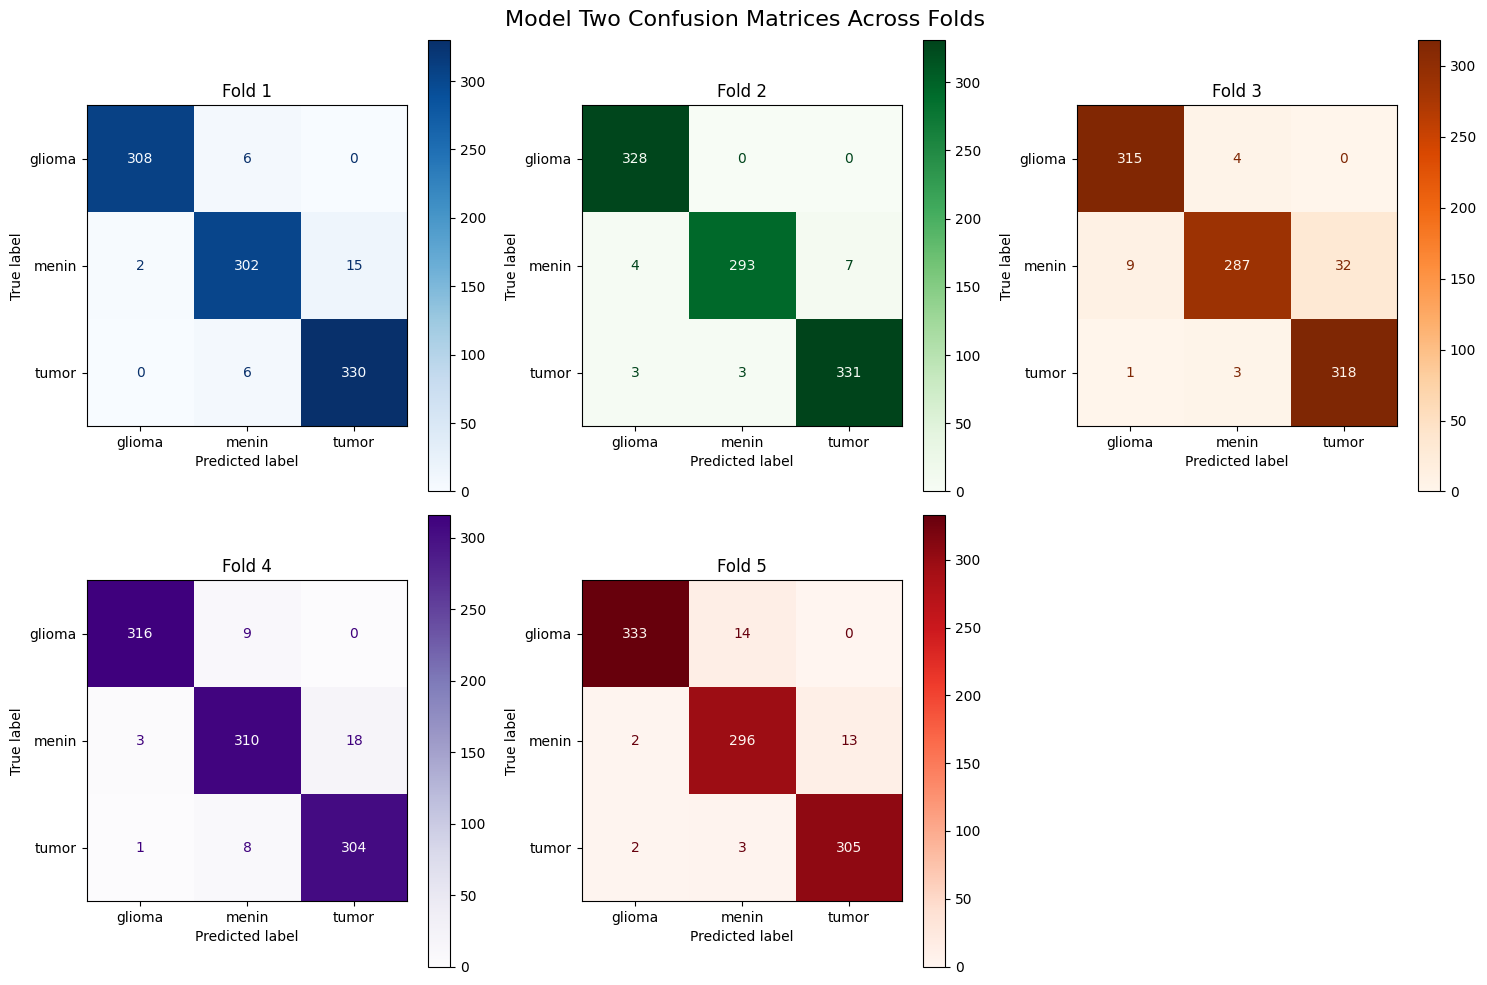

In [69]:
class_reports_one = []
class_reports_two = []

for fold in range(k_fold_count):
    class_report_one = metrics.classification_report(model_one_data['true_labels'][fold], model_one_data['predicted_labels'][fold], target_names=class_names)
    class_reports_one.append(class_report_one)
    print(f'Classification Report Model One - Fold {fold + 1}:\n', class_report_one)
    class_report_two = metrics.classification_report(model_two_data['true_labels'][fold], model_two_data['predicted_labels'][fold], target_names=class_names)
    class_reports_two.append(class_report_two)
    print(f'Classification Report Model Two - Fold {fold + 1}:\n', class_report_two)
    
    train_losses_one = model_one_data['train_loss'][fold]
    train_losses_two = model_two_data['train_loss'][fold]

    val_losses_one = model_one_data['val_loss'][fold]
    val_accuracies_one = model_one_data['val_accuracy'][fold]

    val_losses_two = model_two_data['val_loss'][fold]
    val_accuracies_two = model_two_data['val_accuracy'][fold]

    fpr_one = dict()
    fpr_two = dict()

    tpr_one = dict()
    tpr_two = dict()

    ROC_auc_one = dict()
    ROC_auc_two = dict()

    true_labels_list_one = np.array(model_one_data['true_labels'][fold])
    val_probs_one = np.array(model_one_data['val_probs'][fold])

    true_labels_list_two = np.array(model_two_data['true_labels'][fold])
    val_probs_two = np.array(model_two_data['val_probs'][fold])

    for class_index in range(len(class_names)):
        binary_true_labels_one = (true_labels_list_one == class_index).astype(int)
        class_probabilities_one = val_probs_one[:, class_index]

        fpr_one[class_index], tpr_one[class_index], _ = metrics.roc_curve(binary_true_labels_one, class_probabilities_one) # roc for target class
        ROC_auc_one[class_index] = metrics.roc_auc_score(binary_true_labels_one, class_probabilities_one)

        binary_true_labels_two = (true_labels_list_two == class_index).astype(int)
        class_probabilities_two = val_probs_two[:, class_index]

        fpr_two[class_index], tpr_two[class_index], _ = metrics.roc_curve(binary_true_labels_two, class_probabilities_two) # roc for target class
        ROC_auc_two[class_index] = metrics.roc_auc_score(binary_true_labels_two, class_probabilities_two)

    epoch_range = range(len(val_losses_one))
    plt.figure(1)
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, train_losses_one, label=f'Fold {fold + 1}')
    if len(epoch_range) < 150:
        plt.vlines(len(epoch_range), ymin=0, ymax=max(val_losses_one), colors='black', linestyles='dashed', label=f'Fold {fold + 1} stop')
    plt.title('Model One Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, val_losses_one, label=f'Fold {fold + 1}')
    if len(epoch_range) < 150:
        plt.vlines(len(epoch_range), ymin=0, ymax=max(val_losses_one), colors='black', linestyles='dashed', label=f'Fold {fold + 1} stop')
    plt.title('Model One Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.suptitle('Model One Loss')
    plt.legend()
    plt.tight_layout()

    plt.figure(2)
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, train_losses_two, label=f'Fold {fold + 1}')
    if len(epoch_range) < 150:
        plt.vlines(len(epoch_range), ymin=0, ymax=max(val_losses_two), colors='black', linestyles='dashed', label=f'Fold {fold + 1} stop')
    plt.title('Model Two Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, val_losses_two, label=f'Fold {fold + 1}')
    if len(epoch_range) < 150:
        plt.vlines(len(epoch_range), ymin=0, ymax=max(val_losses_two), colors='black', linestyles='dashed', label=f'Fold {fold + 1} stop')
    plt.title('Model Two Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.suptitle('Model Two Loss')
    plt.legend()
    plt.tight_layout()

    plt.figure(3)
    plt.plot(epoch_range, val_accuracies_one, label=f'Fold {fold + 1} (Final: {val_accuracies_one[-1]:.2f})')
    if len(epoch_range) < 150:
        plt.vlines(len(epoch_range), ymin=0, ymax=max(val_accuracies_one), colors='black', linestyles='dashed', label=f'Fold {fold + 1} stop')
    plt.title('Model One Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.tight_layout()

    plt.figure(4)
    plt.plot(epoch_range, val_accuracies_two, label=f'Fold {fold + 1} (Final: {val_accuracies_two[-1]:.2f})')
    if len(epoch_range) < 150:
        plt.vlines(len(epoch_range), ymin=0, ymax=max(val_accuracies_two), colors='black', linestyles='dashed', label=f'Fold {fold + 1} stop')
    plt.title('Model Two Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.tight_layout()

# AFTER the loop - Create confusion matrix figures separately
# Define color schemes for each fold (consistent between models)
color_schemes = [plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges, plt.cm.Purples, plt.cm.Reds]

# Calculate grid layout: 3 columns, rows as needed
n_cols = 3
n_rows = (k_fold_count + n_cols - 1) // n_cols  # Ceiling division

# Figure 5: Model One Confusion Matrices
fig_cm_one, axes_cm_one = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes_cm_one = axes_cm_one.flatten() if k_fold_count > 1 else [axes_cm_one]

for fold in range(k_fold_count):
    cm_one = metrics.confusion_matrix(model_one_data['true_labels'][fold], model_one_data['predicted_labels'][fold])
    disp_one = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_one, display_labels=class_names)
    disp_one.plot(cmap=color_schemes[fold % len(color_schemes)], ax=axes_cm_one[fold])
    axes_cm_one[fold].set_title(f'Fold {fold + 1}')

# Hide unused subplots for Model One
for idx in range(k_fold_count, len(axes_cm_one)):
    axes_cm_one[idx].axis('off')

fig_cm_one.suptitle('Model One Confusion Matrices Across Folds', fontsize=16)
fig_cm_one.tight_layout()

# Figure 6: Model Two Confusion Matrices
fig_cm_two, axes_cm_two = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes_cm_two = axes_cm_two.flatten() if k_fold_count > 1 else [axes_cm_two]

for fold in range(k_fold_count):
    cm_two = metrics.confusion_matrix(model_two_data['true_labels'][fold], model_two_data['predicted_labels'][fold])
    disp_two = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_two, display_labels=class_names)
    disp_two.plot(cmap=color_schemes[fold % len(color_schemes)], ax=axes_cm_two[fold])
    axes_cm_two[fold].set_title(f'Fold {fold + 1}')

# Hide unused subplots for Model Two
for idx in range(k_fold_count, len(axes_cm_two)):
    axes_cm_two[idx].axis('off')

fig_cm_two.suptitle('Model Two Confusion Matrices Across Folds', fontsize=16)
fig_cm_two.tight_layout()

plt.show()

In [80]:
model_two

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (3): ReLU()
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Dropout2d(p=0.1, inplace=False)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (11): ReLU()
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (14): Dropout2d(p=0.15, inplace=False)
  (15): AdaptiveAvgPool2d(output_size=(1, 1))
  (16): Flatten(start_dim=1, end_dim=-1)
  (17): Linear(in_features=64, out_features=32, bias=T

In [95]:
# Testing 
def evaluate_model(model, data_loader, state_path):
    """ Evaluate the model on the provided data loader using the saved state.
     Args:
         model: The PyTorch model to evaluate.
         data_loader: DataLoader for the evaluation dataset.
         state_path: Path to the saved model state.
         Returns:
         average_loss: Average loss over the dataset.
         accuracy: Accuracy of the model on the dataset.
         all_true_labels: List of true labels.
         all_predicted_labels: List of predicted labels.
         all_probabilities: List of predicted probabilities for each class.
    """
    print('Running Test')
    model.load_state_dict(torch.load(state_path))
    model.eval()
    all_true_labels = []
    all_predicted_labels = []
    all_probabilities = []
    total_loss = 0.0

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(mps_device)
            labels = labels.to(mps_device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            labels_arr = labels.detach().cpu().numpy()
            predicted_arr = predicted.detach().cpu().numpy()
            all_true_labels.extend(labels_arr)
            all_predicted_labels.extend(predicted_arr)

            probabilities = nn.functional.softmax(outputs, dim=1)
            probabilities_arr = probabilities.detach().cpu().numpy()
            all_probabilities.extend(probabilities_arr)

    average_loss = total_loss / len(data_loader)
    accuracy = metrics.accuracy_score(all_true_labels, all_predicted_labels)

    return average_loss, accuracy, all_true_labels, all_predicted_labels, all_probabilities


test_loader = DataLoader(test_set, batch_size=10, shuffle=False)

model_one_state_path = 'model_one_20251202_230750_111'
model_two_state_path = 'model_two_20251202_230750_143'

test_loss_one, test_accuracy_one, test_true_labels_one, test_predicted_one, test_probs_one = evaluate_model(model_one, test_loader, model_one_state_path)
test_loss_two, test_accuracy_two, test_true_labels_two, test_predicted_two, test_probs_two = evaluate_model(model_two, test_loader, model_two_state_path)


class_report_test_one = metrics.classification_report(test_true_labels_one, test_predicted_one)
class_report_test_two = metrics.classification_report(test_true_labels_two, test_predicted_two)

print('Model One: \n',class_report_test_one)
print('Model Two: \n',class_report_test_two)

Running Test
Running Test
Model One: 
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       371
         1.0       0.94      0.94      0.94       411
         2.0       0.96      0.96      0.96       430

    accuracy                           0.96      1212
   macro avg       0.96      0.96      0.96      1212
weighted avg       0.96      0.96      0.96      1212

Model Two: 
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       371
         1.0       0.97      0.95      0.96       411
         2.0       0.96      0.98      0.97       430

    accuracy                           0.97      1212
   macro avg       0.97      0.97      0.97      1212
weighted avg       0.97      0.97      0.97      1212



Model One ROC AUCs: {0: 0.9986859437648032, 1: 0.9913976142959986, 2: 0.9959109022779992}


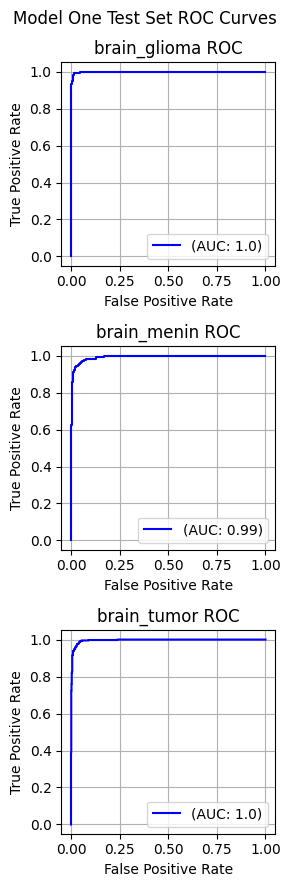

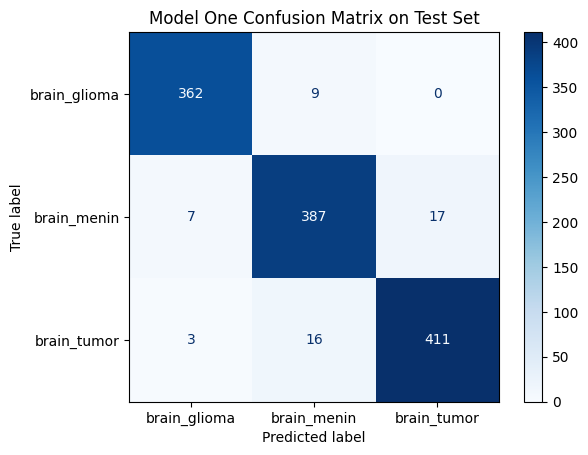

Model Two ROC AUCs: {0: 0.9988686296316476, 1: 0.99420128732029, 2: 0.9971034318681972}


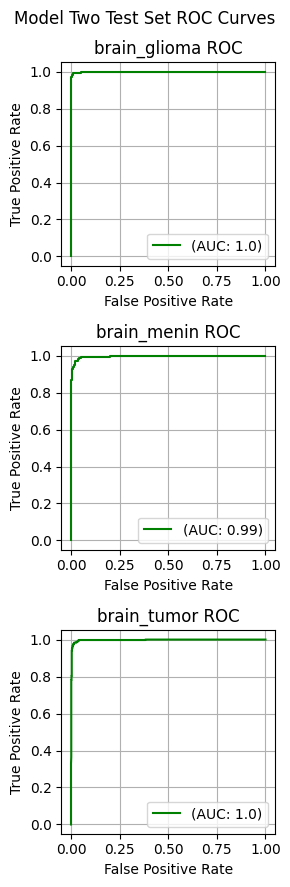

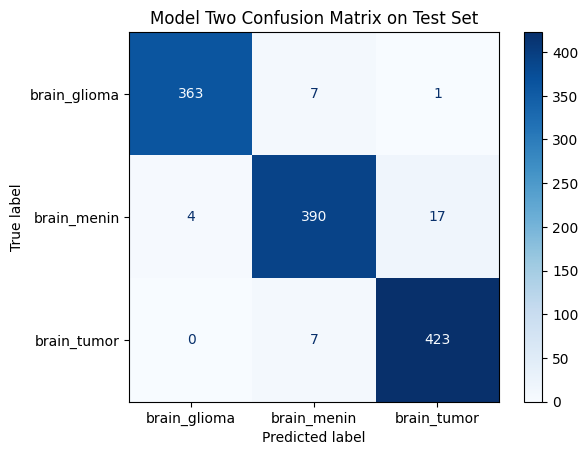

In [92]:
# PLOTTING CODE STARTS HERE
# Convert to numpy arrays
test_probs_one = np.array(test_probs_one)
test_true_labels_one = np.array(test_true_labels_one)
test_probs_two = np.array(test_probs_two)
test_true_labels_two = np.array(test_true_labels_two)

# Calculate ROC curves for Model One
fpr_one = dict()
tpr_one = dict()
ROC_auc_one = dict()

ordered_label_keys = label_encoder.inverse_transform([0, 1, 2])

for class_index in range(len(class_names)):
    binary_true_labels_one = (test_true_labels_one == class_index).astype(int)
    class_probabilities_one = test_probs_one[:, class_index]
    fpr_one[class_index], tpr_one[class_index], _ = metrics.roc_curve(binary_true_labels_one, class_probabilities_one)
    ROC_auc_one[class_index] = metrics.roc_auc_score(binary_true_labels_one, class_probabilities_one)

print('Model One ROC AUCs:', ROC_auc_one)

# Plot ROC curves for Model One
plt.figure(figsize=(3, 9))
for i in range(len(class_names)):
    plt.subplot(3, 1, (i+1))
    plt.plot(fpr_one[i], tpr_one[i], color='Blue', label=f'(AUC: {round(ROC_auc_one[i], 2)})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title(ordered_label_keys[i] + ' ROC')
    plt.grid(True)
plt.suptitle('Model One Test Set ROC Curves')
plt.tight_layout()
plt.show()

# Plot confusion matrix for Model One
cm_one = metrics.confusion_matrix(test_true_labels_one, test_predicted_one)
disp_one = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_one, display_labels=ordered_label_keys)
disp_one.plot(cmap=plt.cm.Blues)
plt.title('Model One Confusion Matrix on Test Set')
plt.show()

# Calculate ROC curves for Model Two
fpr_two = dict()
tpr_two = dict()
ROC_auc_two = dict()

for class_index in range(len(class_names)):
    binary_true_labels_two = (test_true_labels_two == class_index).astype(int)
    class_probabilities_two = test_probs_two[:, class_index]
    fpr_two[class_index], tpr_two[class_index], _ = metrics.roc_curve(binary_true_labels_two, class_probabilities_two)
    ROC_auc_two[class_index] = metrics.roc_auc_score(binary_true_labels_two, class_probabilities_two)

print('Model Two ROC AUCs:', ROC_auc_two)

# Plot ROC curves for Model Two
plt.figure(figsize=(3, 9))
for i in range(len(class_names)):
    plt.subplot(3, 1, (i+1))
    plt.plot(fpr_two[i], tpr_two[i], color='Green', label=f'(AUC: {round(ROC_auc_two[i], 2)})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title(ordered_label_keys[i] + ' ROC')
    plt.grid(True)
plt.suptitle('Model Two Test Set ROC Curves')
plt.tight_layout()
plt.show()

# Plot confusion matrix for Model Two
cm_two = metrics.confusion_matrix(test_true_labels_two, test_predicted_two)
disp_two = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_two, display_labels=ordered_label_keys)
disp_two.plot(cmap=plt.cm.Blues)
plt.title('Model Two Confusion Matrix on Test Set')
plt.show()

In [99]:
print(test_probs_one)

[array([9.9968290e-01, 3.1709680e-04, 2.7392062e-09], dtype=float32), array([8.9615874e-15, 3.2842977e-13, 1.0000000e+00], dtype=float32), array([6.1284665e-11, 1.5740466e-07, 9.9999988e-01], dtype=float32), array([2.5161706e-10, 1.5078974e-06, 9.9999845e-01], dtype=float32), array([1.8323459e-05, 9.9993622e-01, 4.5413577e-05], dtype=float32), array([1.0502722e-07, 9.9999976e-01, 1.6860194e-07], dtype=float32), array([3.3402884e-01, 6.6597122e-01, 8.0808788e-12], dtype=float32), array([9.9994159e-01, 5.8349771e-05, 1.6166139e-08], dtype=float32), array([2.2818820e-07, 9.9999952e-01, 2.2180932e-07], dtype=float32), array([4.900789e-06, 9.999951e-01, 2.978375e-08], dtype=float32), array([9.9999988e-01, 1.4421002e-07, 4.5958921e-09], dtype=float32), array([3.652017e-05, 9.999635e-01, 6.823593e-13], dtype=float32), array([1.2052466e-06, 9.9999881e-01, 4.7073630e-12], dtype=float32), array([2.0943546e-07, 6.3604540e-01, 3.6395440e-01], dtype=float32), array([1.0000000e+00, 6.2331973e-11, 2.

In [ ]:
# soft voting ensemble (early iteration)
prediction_count = len(test_probs_one)
ensembled_probs_avg = np.zeros((len(test_probs_one), test_probs_one[1].shape[0]))
ensembled_pred_avg = np.zeros(prediction_count)

for prediction_index in range(prediction_count):
    current_probs = test_probs_one[prediction_index] + test_probs_two[prediction_index]
    current_probs = current_probs / 2
    ensembled_probs_avg[prediction_index, :] = current_probs / 2
    ensembled_pred_avg[prediction_index] = np.argmax(current_probs)

class_report_ensm = metrics.classification_report(test_true_labels_one, ensembled_pred_avg)
print(class_report_ensm)


ensembled_pred_vote = np.zeros(prediction_count)
for prediction_index in range(prediction_count):
    current_probs_one = test_probs_one[prediction_index] 
    current_probs_two = test_probs_two[prediction_index, :]
    
    if np.max(current_probs_one) >= np.max(current_probs_two):
        ensembled_pred_vote[prediction_index] = np.argmax(current_probs_one)
    else:
        ensembled_pred_vote[prediction_index] = np.argmax(current_probs_two)

class_report_ensm = metrics.classification_report(test_true_labels_one, ensembled_pred_vote)
print(class_report_ensm)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       371
         1.0       0.97      0.95      0.96       411
         2.0       0.97      0.99      0.98       430

    accuracy                           0.97      1212
   macro avg       0.98      0.97      0.97      1212
weighted avg       0.97      0.97      0.97      1212

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       371
         1.0       0.97      0.95      0.96       411
         2.0       0.97      0.99      0.98       430

    accuracy                           0.97      1212
   macro avg       0.98      0.97      0.97      1212
weighted avg       0.97      0.97      0.97      1212

